In [4]:
# Let's start with necessary imports
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

2025-01-12 08:53:41.469342: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 08:53:42.359141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# the gdown folder is necessary to import from Google Drive
!pip install gdown

# Import data from Google Drive
!gdown --id "1H_KW7RYiCJ2PogFyXQRAShlAAIcm_iVM"
# Unzip the data in the /content folder
!unzip /content/Datasets.zip -d /content

/opt/conda/lib/python3.11/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
^C
Traceback (most recent call last):
  File "/opt/conda/bin/gdown", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/gdown/__main__.py", line 172, in main
    download(
  File "/opt/conda/lib/python3.11/site-packages/gdown/download.py", line 202, in download
    res = sess.get(url, stream=True, verify=verify)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/requests/sessions.py", line 602, in get
    return self.request("GET", url, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/requests/sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [6]:
# load data and normalize it
background = np.load('/content/background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load('/content/bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

sglf = np.load('/content/sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)

In [7]:
# Create train and test datasets

x_train, x_test, y_train, y_test = train_test_split(
     background, background, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (80000, 200, 2) (20000, 200, 2)
y train/test shapes: (80000, 200, 2) (20000, 200, 2)


In [24]:
class Model:
    def __init__(self):
        super().__init__()

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout=0):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs  # Adding input directly, assuming output_dim matches inputs shape[-1]

    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        encoder_output = x

        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)

        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 4
ff_dim = 128
num_transformer_blocks = 4
num_dense_blocks = 1
dropout = 0.1

# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)

# Assuming x_train is your input data
history = autoencoder.fit(
    x_train, # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/50
  11/2000 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 1.1189   

I0000 00:00:1736678747.672646    1136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 44 bytes spill stores, 44 bytes spill loads



2000/2000 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - loss: 0.5933 - val_loss: 0.3127
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.2110 - val_loss: 0.0275
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0515 - val_loss: 0.0068
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0344 - val_loss: 0.0041
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0311 - val_loss: 0.0029
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0282 - val_loss: 0.0021
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0256 - val_loss: 0.0021
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0234 - val_loss: 0.0020
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0213 - val_loss: 0.0010
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0190 - val_loss: 0.0032
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0171 - val_loss: 0.0014
Epoch 12/50
2000/20

In [25]:
# Save the entire model as a SavedModel.
__file__=''
!mkdir -p saved_model
autoencoder.save('')

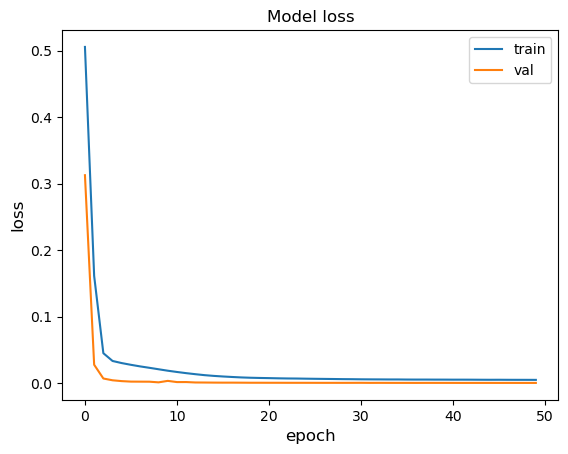

In [26]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


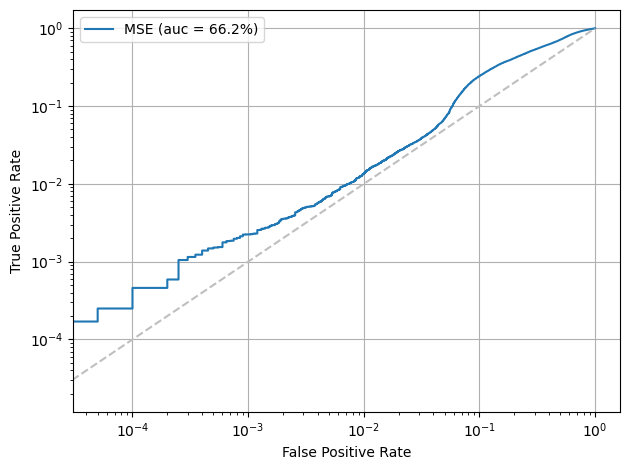

In [27]:
def make_plot_roc_curves(qcd, bsm):

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# evaluate on test background and signal samples
background_test = autoencoder.predict(x_test)
signal_test = autoencoder.predict(bbh)

make_plot_roc_curves(background_test, signal_test)

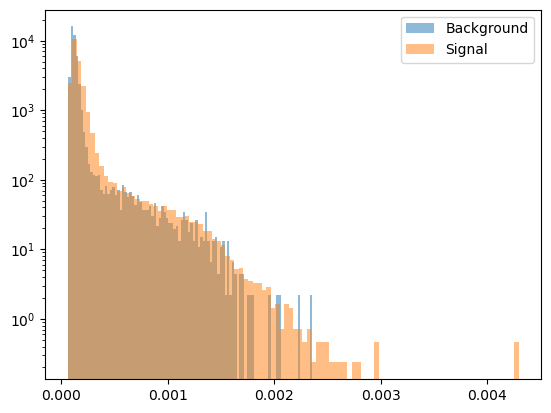

In [28]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [29]:
pretrained_model = Model()
pretrained_model.load()

# Check its architecture
pretrained_model.ae.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 2)    │      2,818 │ input_layer_3[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 200, 2)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 2)    │          4 │ dropout_49[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 200, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 200, 192)  │        576 │ add_28[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 200, 192)  │          0 │ conv1d_20[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 200, 2)    │        386 │ dropout_50[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 2)    │          4 │ conv1d_21[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 200, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_28[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 2)    │      2,818 │ add_29[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_29[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 200, 2)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 2)    │          4 │ dropout_52[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 200, 2)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_29[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 200, 192)  │        576 │ add_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 200, 192)  │          0 │ conv1d_22[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 200, 2)    │        386 │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 2)    │          4 │ conv1d_23[0][0]   │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 846,260 (3.23 MB)

 Trainable params: 282,086 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 564,174 (2.15 MB)